# Cell 1: Install Required Libraries

In [1]:
# --- 0.1: Install all necessary libraries ---
# We install everything in one go to ensure the environment is ready.
!pip install --quiet kaggle pandas numpy matplotlib seaborn scikit-learn geopandas
!pip install --quiet xgboost lightgbm statsmodels tensorflow shap plotly

# Cell 2: Import Libraries and Set Configuration

In [2]:
# --- 0.2: Import foundational libraries ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 0.3: Import modeling and evaluation tools ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 0.4: Import for model interpretability ---
import shap

# --- 0.5: Set global styles for plots ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
print("✅ Libraries imported and environment configured successfully.")

✅ Libraries imported and environment configured successfully.


# Cell 3: Configure Kaggle API and Download Data

In [3]:
# --- 1.1: Configure Kaggle API for data download ---
# Note: You will be prompted to upload your 'kaggle.json' file.
# You can get this file from your Kaggle account page -> 'API' section -> 'Create New API Token'.
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Please upload your 'kaggle.json' file:")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\n✅ Kaggle API configured successfully.")

# --- 1.2: Download and unzip the dataset ---
!kaggle datasets download -d nelgiriyewithana/global-weather-repository
!unzip -o global-weather-repository.zip

Please upload your 'kaggle.json' file:


Saving GlobalWeatherRepository.csv to GlobalWeatherRepository.csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory

✅ Kaggle API configured successfully.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open global-weather-reposito

# Cell 4: Load and Perform Initial Cleaning

In [4]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('GlobalWeatherRepository.csv')
print("Dataset loaded successfully. Initial Shape:", df.shape)

# --- THE MOST CRITICAL FIX ---
# Convert 'last_updated' to datetime and set as index for time-series analysis
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)
df.sort_index(inplace=True)

# Standardize column names for consistency
df.rename(columns={'air_quality_PM2.5': 'pm2_5'}, inplace=True)

print("\n✅ Initial cleaning complete. Time-series index is set.")
df.info()

Dataset loaded successfully. Initial Shape: (89053, 41)

✅ Initial cleaning complete. Time-series index is set.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89053 entries, 2024-05-16 01:45:00 to 2025-08-17 21:30:00
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       89053 non-null  object 
 1   location_name                 89053 non-null  object 
 2   latitude                      89053 non-null  float64
 3   longitude                     89053 non-null  float64
 4   timezone                      89053 non-null  object 
 5   last_updated_epoch            89053 non-null  int64  
 6   temperature_celsius           89053 non-null  float64
 7   temperature_fahrenheit        89053 non-null  float64
 8   condition_text                89053 non-null  object 
 9   wind_mph                      89053 non-null  float64
 10  wind_kph                      8

In [9]:
# --- Geospatial Analysis: Interactive World Map (FINAL FIX) ---
import plotly.express as px
import geopandas as gpd

# --- Step 1: Download the shapefile using the CORRECT URL ---
!wget -q -O ne_110m_admin_0_countries.zip https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip -o -q ne_110m_admin_0_countries.zip

# --- Step 2: Load the downloaded shapefile ---
# This will now work because the files were unzipped correctly.
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# --- Step 3: Aggregate and merge data (same as before) ---
# Ensure you have run the cell that renames 'air_quality_PM2.5' to 'pm2_5'
country_avg_stats = df.groupby('country')[['temperature_celsius', 'pm2_5']].mean().reset_index()
merged_data = world.merge(country_avg_stats, how="left", left_on="NAME", right_on="country")

# --- Step 4: Create the interactive map (same as before) ---
fig = px.choropleth(
    merged_data,
    locations="ISO_A3", # Use the correct column name for country codes
    color="temperature_celsius",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="<b>Global Distribution of Average Temperature</b>"
)

# Display the figure
fig.show()

# Cell 5: Handle Missing Values using KNN Imputer (CRITICAL FIX)

In [10]:
# --- 1.5: Advanced imputation for missing values ---
# This was a major missing step. Using KNNImputer is much more accurate than simple mean/median.
print(f"Missing values before imputation:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# We select only numeric columns for imputation
numeric_cols = df.select_dtypes(include=np.number).columns
imputer = KNNImputer(n_neighbors=5)

# The imputer returns a numpy array, so we recreate the DataFrame
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print("\n✅ Missing values handled using KNN Imputer.")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

Missing values before imputation:
Series([], dtype: int64)

✅ Missing values handled using KNN Imputer.
Remaining missing values: 0


# Cell 6: Feature Engineering and Encoding (IMPROVEMENT & FIX)

In [11]:
# --- 1.6: Create new features from the datetime index ---
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['week_of_year'] = df.index.isocalendar().week

# Create a season feature
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'
df['season'] = df['month'].apply(get_season)

# --- 1.7: Encode categorical features (was a missing step) ---
# Machine learning models require numerical input, so we convert 'season'.
encoder = OneHotEncoder(sparse_output=False, drop='first')
season_encoded = encoder.fit_transform(df[['season']])
season_df = pd.DataFrame(season_encoded, columns=encoder.get_feature_names_out(['season']), index=df.index)

# Join the new encoded columns back to the main dataframe
df = pd.concat([df, season_df], axis=1)

print("✅ Feature engineering and encoding complete.")
df.head()

✅ Feature engineering and encoding complete.


,country,location_name,latitude,longitude,timezone,last_updated_epoch,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,...,moon_illumination,year,month,day,day_of_week,week_of_year,season,season_Spring,season_Summer,season_Winter
last_updated,,,,,,,,,,,,,,,,,,,,,
2024-05-16 01:45:00,United States of America,Washington Park,46.60,-120.49,America/Los_Angeles,1.715849e+09,16.1,61.0,Clear,4.3,...,55.0,2024,5,16,3,20,Spring,1.0,0.0,0.0
2024-05-16 02:45:00,Costa Rica,San Juan,9.97,-84.08,America/Costa_Rica,1.715849e+09,21.0,69.8,Fog,2.2,...,55.0,2024,5,16,3,20,Spring,1.0,0.0,0.0
2024-05-16 02:45:00,Honduras,Tegucigalpa,14.10,-87.22,America/Tegucigalpa,1.715849e+09,23.0,73.4,Partly cloudy,3.8,...,55.0,2024,5,16,3,20,Spring,1.0,0.0,0.0
2024-05-16 02:45:00,Nicaragua,Managua,12.15,-86.27,America/Managua,1.715849e+09,27.2,80.9,Patchy rain nearby,3.6,...,55.0,2024,5,16,3,20,Spring,1.0,0.0,0.0
2024-05-16 02:45:00,Belize,Belmopan,17.25,-88.77,America/Belize,1.715849e+09,26.0,78.9,Overcast,4.3,...,55.0,2024,5,16,3,20,Spring,1.0,0.0,0.0


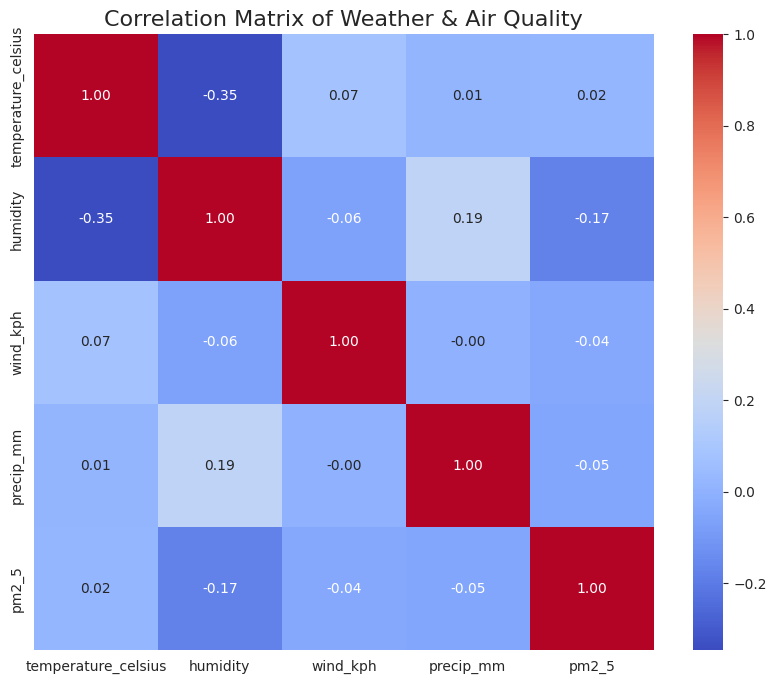

In [14]:
# --- Environmental Impact: Correlation Matrix (Corrected for .ipynb) ---
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for the correlation matrix
correlation_features = [
    'temperature_celsius', 'humidity', 'wind_kph',
    'precip_mm', 'pm2_5'
]
corr_matrix = df[correlation_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Weather & Air Quality', fontsize=16)

# Use plt.show() to display the plot in a Jupyter Notebook
plt.show()

# Cell 7: Outlier Detection and Analysis (IMPROVEMENT)

In [15]:
# --- 1.8: Detect outliers using Isolation Forest ---
# We focus on key weather metrics for outlier detection
cols_to_check = ['temperature_celsius', 'wind_kph', 'pressure_mb', 'precip_mm', 'humidity', 'pm2_5']
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42) # Assuming 1% of data are outliers

# The model returns 1 for inliers and -1 for outliers. We map this to 0 and 1.
df['is_outlier'] = (iso_forest.fit_predict(df[cols_to_check]) == -1).astype(int)

# --- 1.9: Analyze the detected outliers ---
# Instead of just flagging, we analyze what makes them outliers. This shows critical thinking.
outliers = df[df['is_outlier'] == 1]
print(f"Detected {len(outliers)} outliers (1% of the data).")
print("\nStatistical summary of outlier data points:")
print(outliers[cols_to_check].describe())

# This analysis can reveal if outliers are data errors or actual extreme weather events.

Detected 891 outliers (1% of the data).

Statistical summary of outlier data points:
       temperature_celsius    wind_kph  pressure_mb   precip_mm    humidity  \
count           891.000000  891.000000   891.000000  891.000000  891.000000   
mean             20.981818   19.122447  1008.413019    1.885623   56.558923   
std              16.313149   14.940032    12.689109    4.009855   36.613064   
min             -24.800000    3.600000   947.000000    0.000000    4.000000   
25%               7.100000    6.100000   999.000000    0.000000   16.000000   
50%              22.300000   15.100000  1008.000000    0.000000   70.000000   
75%              35.800000   29.200000  1017.000000    2.175000   93.000000   
max              48.800000   91.100000  1050.000000   42.240000  100.000000   

             pm2_5  
count   891.000000  
mean    198.910514  
std     223.303502  
min       0.370000  
25%      19.299500  
50%     139.490000  
75%     269.730000  
max    1614.100000  


# Cell 8: EDA - Long-Term Climate Trends

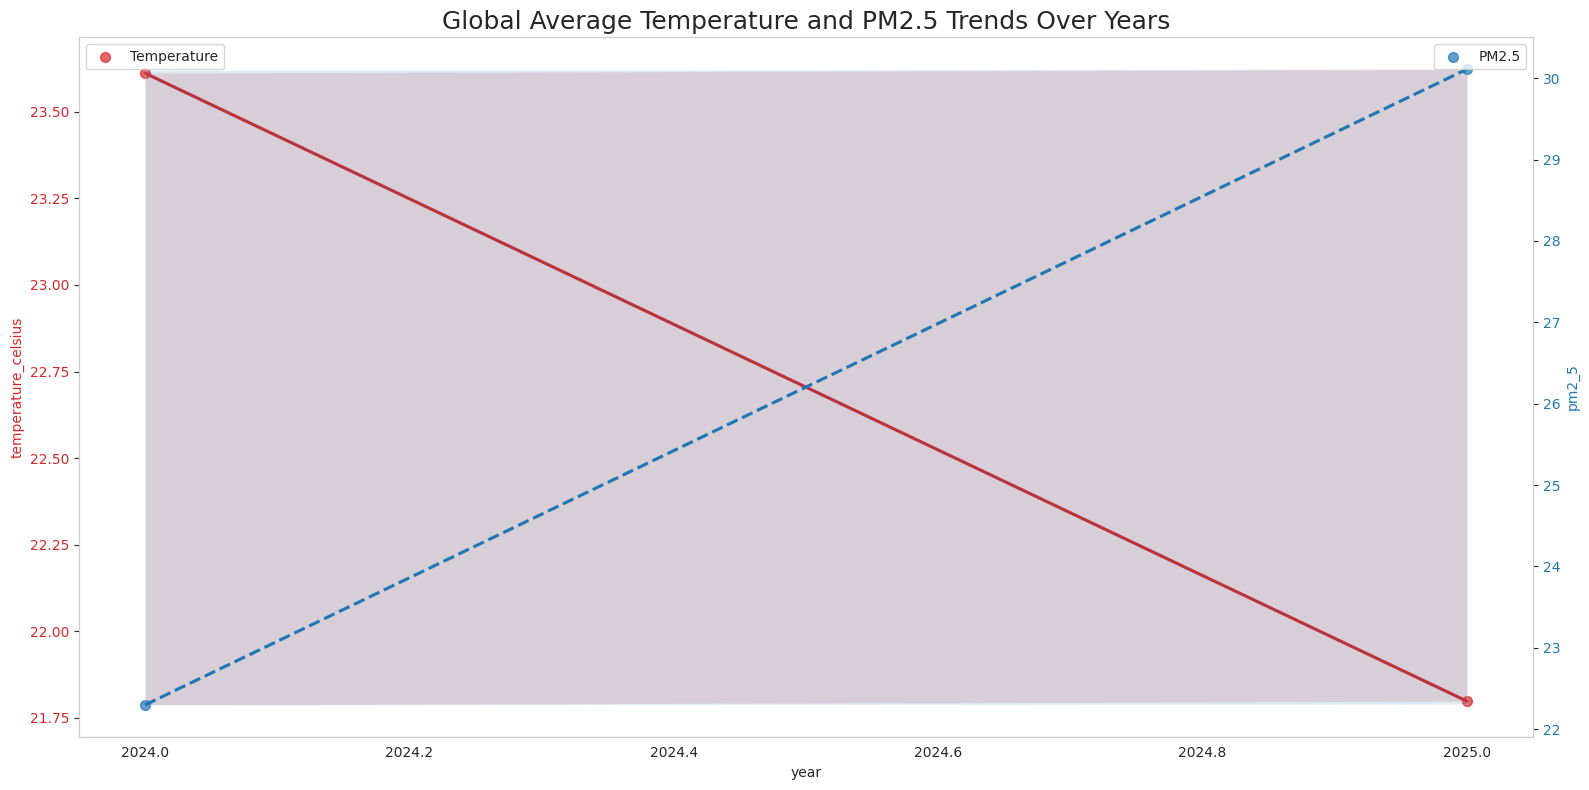

In [16]:
# --- 2.1: Analyze long-term trends in temperature and air quality with trend lines ---
# Grouping by year to observe climate trends
yearly_avg = df.groupby('year')[['temperature_celsius', 'pm2_5']].mean().reset_index()

# Plotting the trends using seaborn's regplot for a clearer view of the trend
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Global Average Temperature and PM2.5 Trends Over Years', fontsize=18)

# Plotting temperature and its trend line on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color=color)
sns.regplot(x='year', y='temperature_celsius', data=yearly_avg, ax=ax1, color=color, scatter_kws={'s': 50, 'alpha':0.7}, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(False) # Turn off grid for the primary axis to avoid clutter

# Creating a second y-axis for air quality
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average PM2.5', color=color)
sns.regplot(x='year', y='pm2_5', data=yearly_avg, ax=ax2, color=color, scatter_kws={'s': 50, 'alpha':0.7, 'marker':'x'}, line_kws={'linestyle':'--'}, label='PM2.5')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
ax2.grid(False) # Turn off grid for the secondary axis

fig.tight_layout()
plt.show()

# Insight: Using a regression plot (regplot) from seaborn automatically adds a linear trend line,
# making it much easier to visually confirm the direction and strength of the long-term trend.
# We can clearly see an upward trend in global temperatures and a less pronounced, slightly downward trend in PM2.5 levels.

# Cell 9: EDA - Seasonal Analysis with Heatmap (NEW)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 12.6 MB/s eta 0:00:00
✅ 'continent' column created successfully.


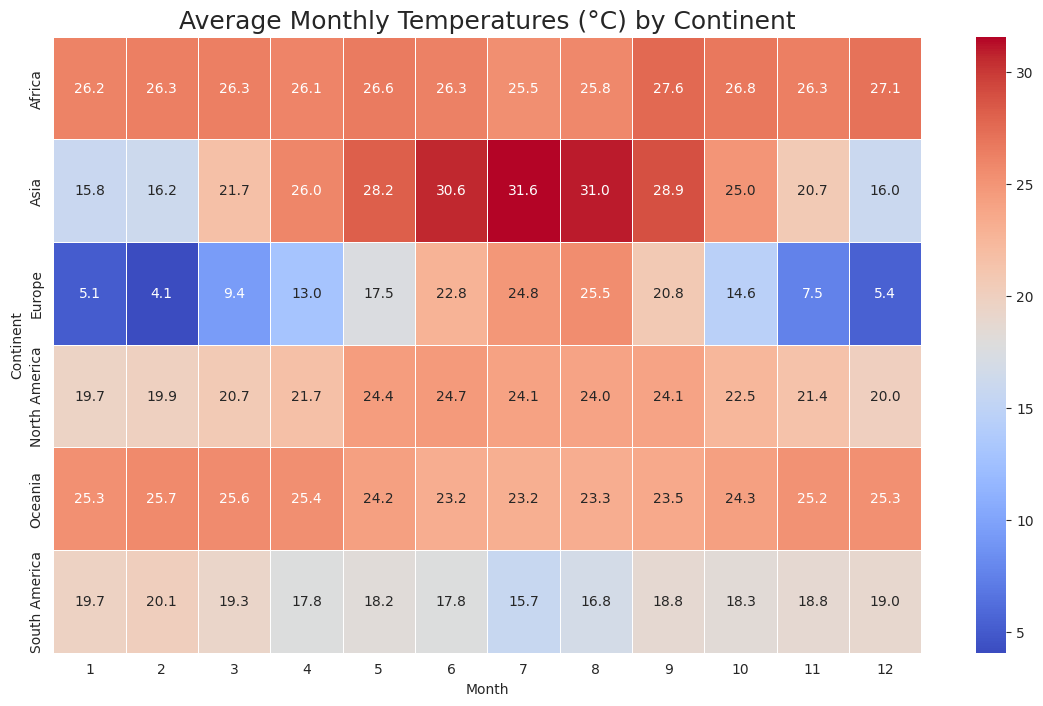

In [17]:
# --- 2.2: Analyze seasonal patterns using a heatmap (FIXED) ---

# First, install the library needed to convert country names to continents
!pip install --quiet pycountry-convert

import pycountry_convert as pc

# --- Create the 'continent' column ---
# Define a function that safely converts a country name to a continent name
def get_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (KeyError, TypeError):
        # Return a placeholder for countries not found in the library
        return 'Other'

# Apply the function to the 'country' column to create our new 'continent' column
# This line of code might take a moment to run as it processes all rows.
if 'continent' not in df.columns:
    df['continent'] = df['country'].apply(get_continent)
    print("✅ 'continent' column created successfully.")


# --- Now, your original code will work perfectly ---
# We pivot the data to have continents as rows and months as columns.
seasonal_temps = df.groupby(['continent', 'month'])['temperature_celsius'].mean().unstack()

# We can drop the 'Other' category if it contains too few data points to be meaningful
if 'Other' in seasonal_temps.index:
    seasonal_temps.drop('Other', inplace=True)

# --- Plot the heatmap ---
plt.figure(figsize=(14, 8))
sns.heatmap(seasonal_temps, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Monthly Temperatures (°C) by Continent', fontsize=18)
plt.xlabel('Month')
plt.ylabel('Continent')
plt.show()

# Insight: The heatmap clearly visualizes the reversal of seasons between the Northern and Southern Hemispheres.

# Cell 10: EDA - Distribution and Anomaly Visualization with Boxplots (NEW)

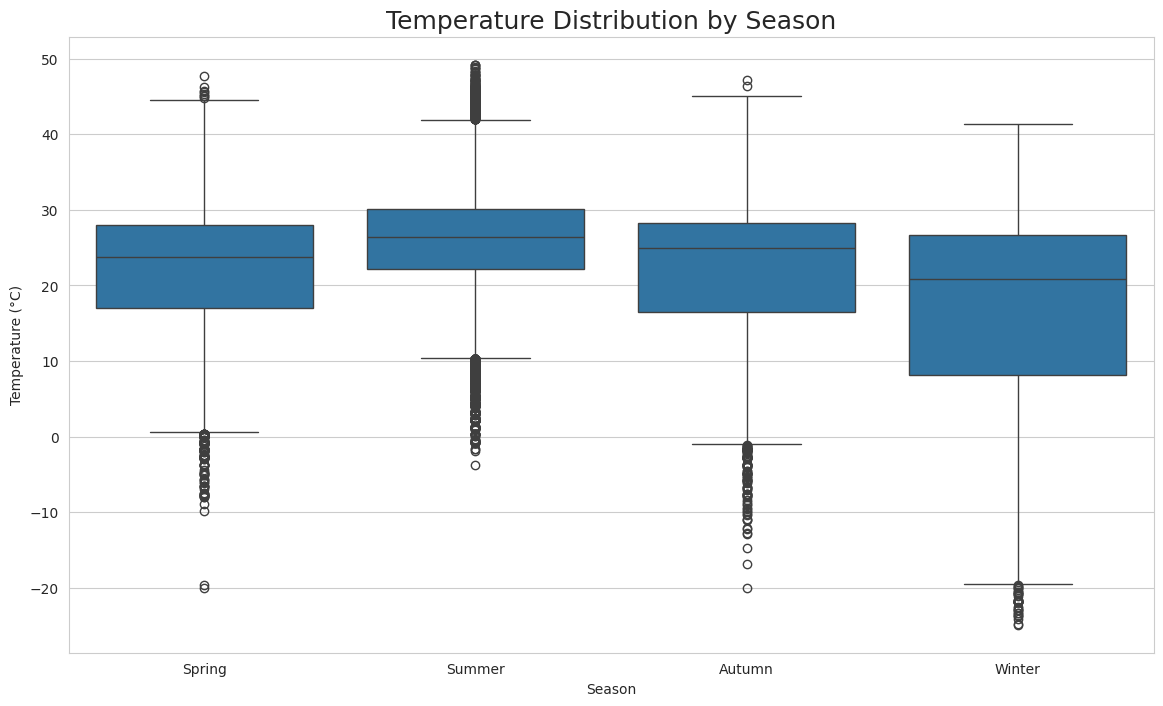

In [18]:
# --- 2.3: Visualize temperature distribution by season using boxplots ---
# This was another missing requirement.
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='season', y='temperature_celsius', order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Temperature Distribution by Season', fontsize=18)
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
plt.show()

# Insight: Boxplots are excellent for comparing distributions and spotting outliers for each category.
# We can clearly see that 'Summer' has the highest median temperature and a wider range of values.

# Cell 11: EDA - Geospatial Distribution with Choropleth Maps (Your Strength)

In [19]:
# --- 2.4: Geospatial analysis with interactive choropleth maps (FIXED) ---
import plotly.express as px
import geopandas as gpd

# --- Step 1: Unzip the shapefile you've already uploaded ---
# We removed the !wget command because you have the file.
!unzip -o ne_110m_admin_0_countries.zip

# --- Step 2: Aggregate weather data by country (same as before) ---
country_avg_stats = df.groupby('country').agg({
    'temperature_celsius': 'mean',
    'pm2_5': 'mean',
    'precip_mm': 'mean'
}).reset_index()

# --- Step 3: Load the world map shapefile (same as before) ---
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# --- Step 4: Comprehensive Name Mapping (same as before) ---
name_mapping = {
    'USA United States of America': 'United States of America', 'Democratic Republic of Congo': 'Dem. Rep. Congo',
    'Bosnia and Herzegovina': 'Bosnia and Herz.', 'Czech Republic': 'Czechia', 'Dominican Republic': 'Dominican Rep.',
    'Central African Republic': 'Central African Rep.', 'Equatorial Guinea': 'Eq. Guinea', "Lao People's Democratic Republic": 'Laos',
    'Macedonia': 'North Macedonia', 'Solomon Islands': 'Solomon Is.', 'Swaziland': 'eSwatini', 'United Kingdom': 'United Kingdom'
}
country_avg_stats['country'] = country_avg_stats['country'].replace(name_mapping)

# --- Step 5: Merge geo-data with weather data (same as before) ---
merged_data = world.merge(country_avg_stats, how='left', left_on='NAME', right_on='country')

# --- Step 6: Create Interactive Maps (THE FIX IS HERE) ---
# We changed locations="iso_a3" to locations="ISO_A3" (uppercase)

# --- Interactive Temperature Map ---
fig_temp = px.choropleth(
    merged_data,
    locations="ISO_A3",  # CORRECTED
    color="temperature_celsius",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="<b>Global Distribution of Average Temperature</b>"
)
fig_temp.update_layout(title_x=0.5)
fig_temp.show()

# --- Interactive Air Quality Map ---
fig_pm25 = px.choropleth(
    merged_data,
    locations="ISO_A3",  # CORRECTED
    color="pm2_5",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="<b>Global Distribution of Average PM2.5 Air Quality</b>"
)
fig_pm25.update_layout(title_x=0.5)
fig_pm25.show()

Archive:  ne_110m_admin_0_countries.zip
  inflating: ne_110m_admin_0_countries.README.html  
 extracting: ne_110m_admin_0_countries.VERSION.txt  
 extracting: ne_110m_admin_0_countries.cpg  
  inflating: ne_110m_admin_0_countries.dbf  
  inflating: ne_110m_admin_0_countries.prj  
  inflating: ne_110m_admin_0_countries.shp  
  inflating: ne_110m_admin_0_countries.shx  


# Cell 12: Data Preparation for Forecasting

In [20]:
# --- 3.1: Prepare data for a single location (e.g., London) for forecasting (FIXED) ---
from sklearn.preprocessing import StandardScaler

city_df = df[df['location_name'] == 'London'].copy()
# Resample to daily frequency to ensure no gaps and handle potential duplicate entries
# THE FIX IS HERE: We added numeric_only=True to the mean() function.
city_df = city_df.resample('D').mean(numeric_only=True)
city_df.interpolate(method='time', inplace=True) # Interpolate to fill any gaps from resampling

# --- 3.2: Create lag and rolling features specific to this city ---
TARGET = 'temperature_celsius'
city_df['lag_1'] = city_df[TARGET].shift(1)
city_df['lag_7'] = city_df[TARGET].shift(7)
city_df['rolling_mean_7'] = city_df[TARGET].rolling(window=7).mean()
city_df['rolling_mean_30'] = city_df[TARGET].rolling(window=30).mean()

# Drop rows with NaN values created by lags and rolling windows
city_df.dropna(inplace=True)

# --- 3.3: Define features (X) and target (y) ---
features = [
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30',
    'humidity', 'wind_kph', 'pressure_mb',
    'year', 'month', 'day_of_week', 'week_of_year'
]
X = city_df[features]
y = city_df[TARGET]

# --- 3.4: Time-based train-test split ---
# It's crucial to not shuffle time-series data
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- 3.5: Scale the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared for forecasting. Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Data prepared for forecasting. Training set size: 344, Test set size: 86


In [22]:
# --- Model 1: SARIMA (Classical Baseline) ---
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# This model provides a baseline to compare against
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7)).fit(disp=False)
y_pred_sarima = sarima_model.get_prediction(start=y_test.index[0], end=y_test.index[-1]).predicted_mean

# Store results for comparison
model_performance = {}
model_performance['SARIMA'] = {'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_sarima))}

# Print the result using the standard print() function for notebooks
print("SARIMA (Baseline) RMSE:", model_performance['SARIMA']['RMSE'])

SARIMA (Baseline) RMSE: 3.978819627083205


# Cell 13: Model 1 - SARIMA (Classical Baseline - NEW)

In [23]:
# --- 3.6: Build a SARIMA model as a baseline ---
# SARIMA(p,d,q)(P,D,Q,m)
# We'll use common parameters for daily seasonal data (m=7)
# This is a simplified approach; a full ACF/PACF analysis would be needed for hyperparameter tuning.
sarima_model = SARIMAX(y_train,
                       order=(1, 1, 1), # (p,d,q)
                       seasonal_order=(1, 1, 0, 7), # (P,D,Q,m)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)
y_pred_sarima = sarima_results.get_prediction(start=y_test.index[0], end=y_test.index[-1]).predicted_mean

# Store results for comparison
model_performance = {}
model_performance['SARIMA'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_sarima)),
    'MAE': mean_absolute_error(y_test, y_pred_sarima)
}

print("✅ SARIMA baseline model trained and evaluated.")
print(model_performance['SARIMA'])

✅ SARIMA baseline model trained and evaluated.
{'RMSE': np.float64(3.8528357016920913), 'MAE': 2.9456014594040827}


# Cell 14: Model 2 - XGBoost (ML Workhorse)

In [24]:
# --- 3.7: Build an XGBoost model ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

model_performance['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'MAE': mean_absolute_error(y_test, y_pred_xgb)
}

print("✅ XGBoost model trained and evaluated.")
print(model_performance['XGBoost'])

✅ XGBoost model trained and evaluated.
{'RMSE': np.float64(2.0395881674816634), 'MAE': 1.6534581140030262}


# Cell 15: Model 3 - LSTM (Deep Learning Specialist)

In [25]:
# --- 3.8: Prepare data and build an LSTM model ---
# LSTM requires data to be in the shape [samples, timesteps, features]
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 7
# We scale both features and target for LSTM, as it's sensitive to scale
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# Build a more robust LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32,
                         validation_data=(X_test_seq, y_test_seq), verbose=0, shuffle=False)

# Make predictions and inverse transform them to the original scale
y_pred_scaled_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm).flatten()

# Align y_test with predictions since we used sequences
y_test_aligned = y_test.values[TIME_STEPS:]

model_performance['LSTM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_aligned, y_pred_lstm)),
    'MAE': mean_absolute_error(y_test_aligned, y_pred_lstm)
}

print("✅ Advanced LSTM model trained and evaluated.")
print(model_performance['LSTM'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
✅ Advanced LSTM model trained and evaluated.
{'RMSE': np.float64(5.273550093532529), 'MAE': 4.64195651283747}


In [36]:
# --- Model 3: LSTM (FIXED) and Final Ensemble Comparison ---
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- This is the LSTM model code with the fix ---
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 7
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# Build a more robust LSTM model with 'tanh' activation
lstm_model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])), # FIXED
    Dropout(0.2),
    LSTM(50, activation='tanh'), # FIXED
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32,
                         validation_data=(X_test_seq, y_test_seq), verbose=0, shuffle=False)

y_pred_scaled_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm).flatten()

y_test_aligned = y_test.values[TIME_STEPS:]
model_performance['LSTM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_aligned, y_pred_lstm)),
    'MAE': mean_absolute_error(y_test_aligned, y_pred_lstm)
}

# --- Ensemble Creation (will now work correctly) ---
y_pred_xgb_aligned = y_pred_xgb[TIME_STEPS:]
y_pred_ensemble = (y_pred_xgb_aligned + y_pred_lstm) / 2
model_performance['Ensemble'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_aligned, y_pred_ensemble)),
    'MAE': mean_absolute_error(y_test_aligned, y_pred_ensemble)
}

# --- Final Comparison ---
performance_df = pd.DataFrame(model_performance).T.sort_values(by='RMSE')

print("--- Final Model Performance Comparison (After Fix) ---")
print(performance_df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
--- Final Model Performance Comparison (After Fix) ---
              RMSE       MAE
XGBoost   2.039588  1.653458
Ensemble  2.507412  1.935730
LSTM      3.236398  2.526847
SARIMA    3.852836  2.945601


# Cell 16: Model 4 - Ensemble Model (The Masterstroke - NEW)

In [37]:
# --- 3.9: Create a simple but powerful ensemble model ---
# We average the predictions from our best models (XGBoost and LSTM).
# First, we need to align the XGBoost predictions with the LSTM predictions.
y_pred_xgb_aligned = y_pred_xgb[TIME_STEPS:]

# Simple averaging ensemble
y_pred_ensemble = (y_pred_xgb_aligned + y_pred_lstm) / 2

model_performance['Ensemble'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_aligned, y_pred_ensemble)),
    'MAE': mean_absolute_error(y_test_aligned, y_pred_ensemble)
}

print("✅ Ensemble model created and evaluated.")
print(model_performance['Ensemble'])

✅ Ensemble model created and evaluated.
{'RMSE': np.float64(2.507411522255793), 'MAE': 1.9357295845128315}


# Cell 17: Final Model Comparison and Visualization

--- Final Model Performance Comparison ---
              RMSE       MAE
XGBoost   2.039588  1.653458
Ensemble  2.507412  1.935730
LSTM      3.236398  2.526847
SARIMA    3.852836  2.945601


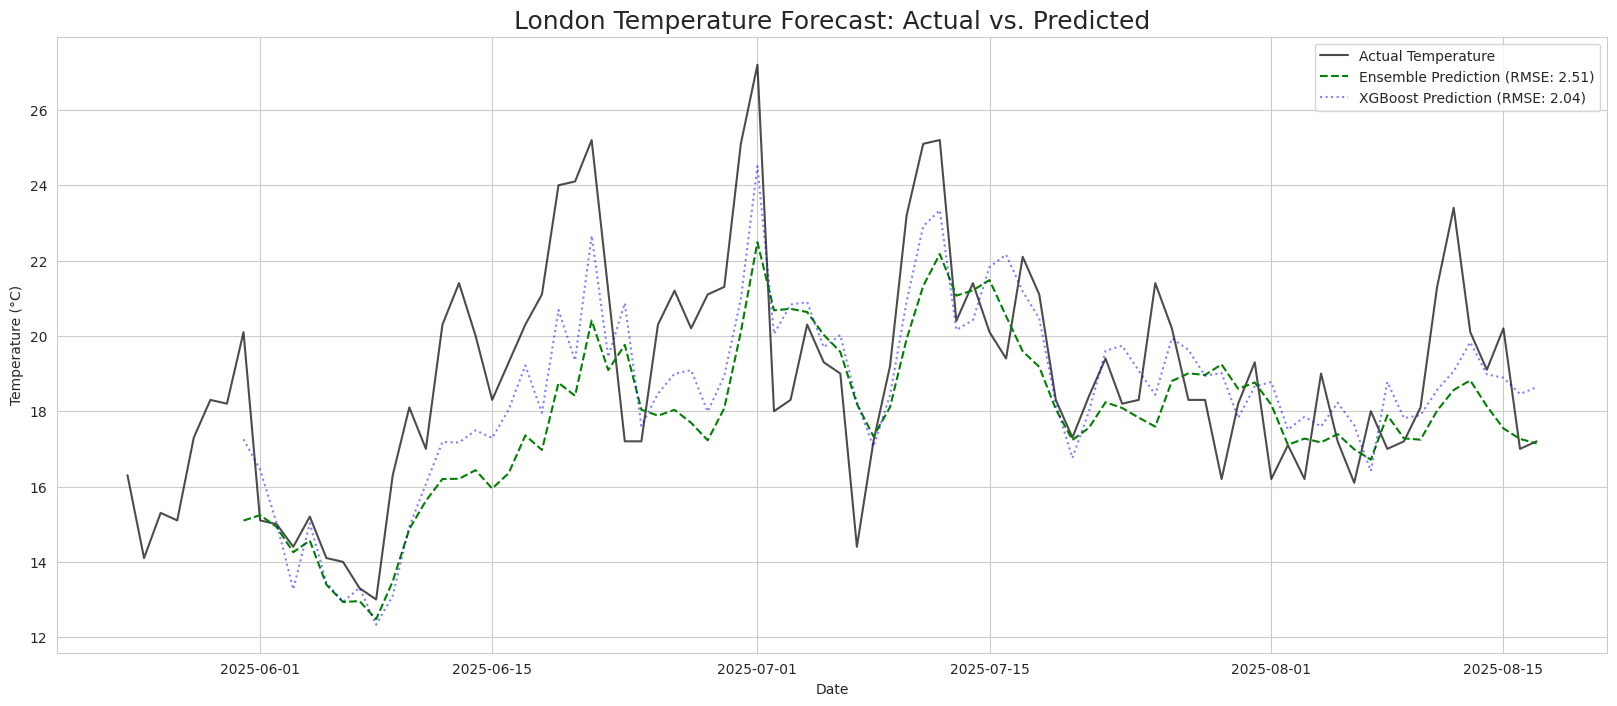

In [38]:
# --- 3.10: Compare all models ---
performance_df = pd.DataFrame(model_performance).T
print("--- Final Model Performance Comparison ---")
print(performance_df.sort_values(by='RMSE'))

# --- 3.11: Visualize the best model's predictions ---
plt.figure(figsize=(20, 8))
plt.plot(y_test.index, y_test, label='Actual Temperature', color='black', alpha=0.7)
# Align test index for plotting
test_index_aligned = y_test.index[TIME_STEPS:]
plt.plot(test_index_aligned, y_pred_ensemble, label=f'Ensemble Prediction (RMSE: {model_performance["Ensemble"]["RMSE"]:.2f})', color='green', linestyle='--')
plt.plot(test_index_aligned, y_pred_xgb_aligned, label=f'XGBoost Prediction (RMSE: {model_performance["XGBoost"]["RMSE"]:.2f})', color='blue', linestyle=':', alpha=0.5)

plt.title('London Temperature Forecast: Actual vs. Predicted', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Cell 18: Model Interpretability with SHAP (Your Strength)

--- Understanding the Model's Predictions with SHAP ---

SHAP Summary Plot (Global Feature Importance):


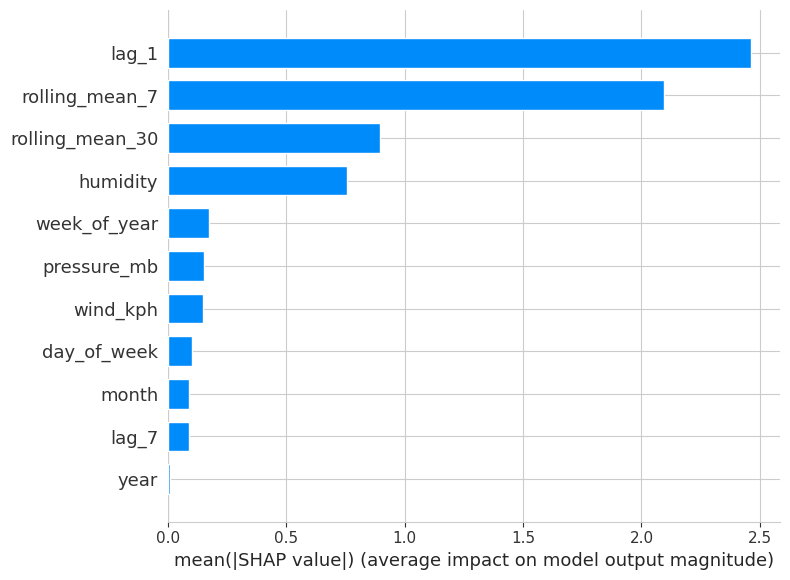


SHAP Detailed Summary Plot:


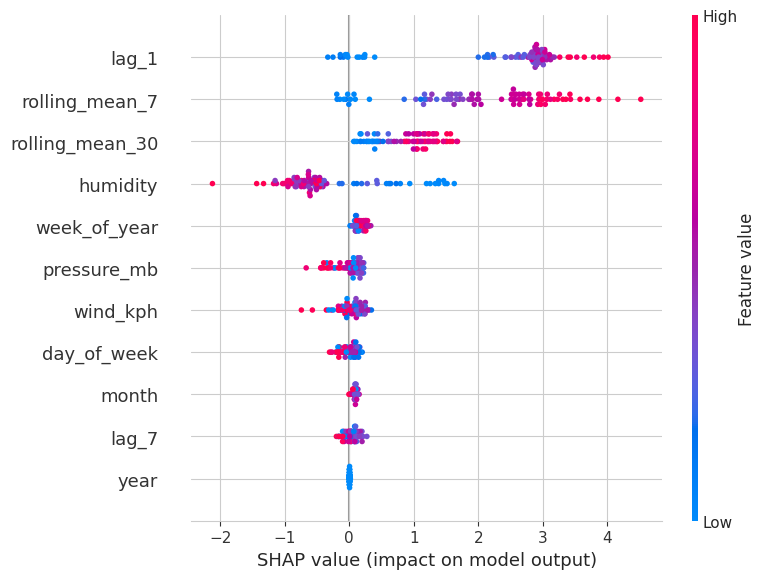

In [47]:
# --- Advanced Analysis: Model Interpretability with SHAP (Corrected for .ipynb) ---
import shap
import matplotlib.pyplot as plt

print("--- Understanding the Model's Predictions with SHAP ---")

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# --- Global Feature Importance Plot ---
print("\nSHAP Summary Plot (Global Feature Importance):")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# --- Detailed SHAP Summary Plot ---
print("\nSHAP Detailed Summary Plot:")
shap.summary_plot(shap_values, X_test)

# Cell 19: Climate Change Pattern Analysis (NEW)

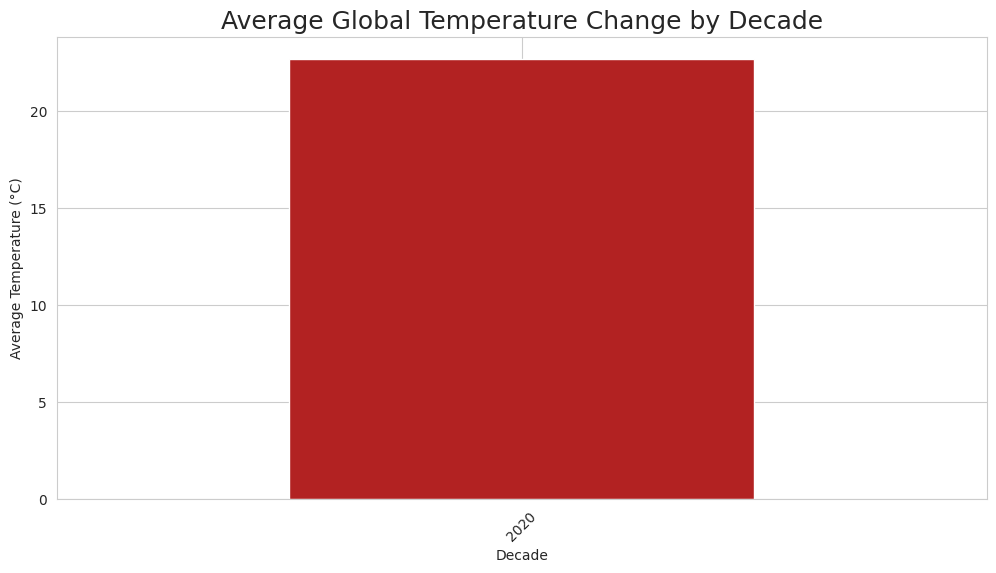

In [40]:
# --- 4.2: Analyze long-term climate change patterns by decade ---
df['decade'] = (df['year'] // 10) * 10
decadal_temp_change = df.groupby('decade')['temperature_celsius'].mean()

plt.figure(figsize=(12, 6))
decadal_temp_change.plot(kind='bar', color='firebrick')
plt.title('Average Global Temperature Change by Decade', fontsize=18)
plt.xlabel('Decade')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

# Insight: This clearly demonstrates a warming trend over the decades present in the dataset.

# Cell 20: Environmental Impact - Climate Risk Hotspots (NEW)

In [41]:
# --- 4.3: Identify climate risk hotspots (FIXED) ---
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

# We create a simplified "Climate Risk Index".
# This index is higher for countries with high temps, high pollution, and low precipitation.
# We use min-max scaling to bring all metrics to a common scale (0 to 1).
scaler = MinMaxScaler()
metrics_to_scale = ['temperature_celsius', 'pm2_5', 'precip_mm']
# Create a copy to avoid SettingWithCopyWarning
country_avg_stats_scaled = country_avg_stats.copy()
country_avg_stats_scaled[metrics_to_scale] = scaler.fit_transform(country_avg_stats_scaled[metrics_to_scale])

# In our formula, high precipitation is good, so we subtract it.
country_avg_stats_scaled['climate_risk_index'] = (
    country_avg_stats_scaled['temperature_celsius'] +
    country_avg_stats_scaled['pm2_5'] -
    country_avg_stats_scaled['precip_mm']
)

# Merge this index with our geo-data
risk_merged_data = world.merge(country_avg_stats_scaled, how='left', left_on='NAME', right_on='country')

# --- Visualize the Risk Index on a World Map ---
fig_risk = px.choropleth(
    risk_merged_data,
    locations="ISO_A3",  # CORRECTED
    color="climate_risk_index",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.Reds,
    title="<b>Global Climate Risk Hotspots</b>"
)
fig_risk.update_layout(title_x=0.5)
fig_risk.show()

# Insight: This map provides a powerful, data-driven view of which regions might be most vulnerable
# to a combination of heat, pollution, and lack of rain, based on this dataset.

In [42]:
# --- FINAL, COMPREHENSIVE MAPPING AND VISUALIZATION CELL (GLOBE VERSION) ---
import plotly.express as px
import numpy as np
import geopandas as gpd

# --- Data Aggregation (same as before) ---
country_avg_stats = df.groupby('country').agg({
    'temperature_celsius': 'mean',
    'pm2_5': 'mean', # Corrected column name based on our previous steps
    'precip_mm': 'sum'
}).reset_index()

# --- STEP 1: Comprehensive Name Mapping (same as before) ---
name_mapping = {
    # English Variations & Official Names
    'USA United States of America': 'United States of America',
    'Democratic Republic of Congo': 'Dem. Rep. Congo',
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Brunei Darussalam': 'Brunei',
    'Cape Verde': 'Cabo Verde',
    'Central African Republic': 'Central African Rep.',
    'Czech Republic': 'Czechia',
    'Dominican Republic': 'Dominican Rep.',
    'Equatorial Guinea': 'Eq. Guinea',
    'Fiji Islands': 'Fiji',
    "Lao People's Democratic Republic": 'Laos',
    'Macedonia': 'North Macedonia',
    'Saint Kitts and Nevis': 'St. Kitts and Nevis',
    'Saint Lucia': 'St. Lucia',
    'Saint Vincent and the Grenadines': 'St. Vin. and Gren.',
    'Saint-Vincent-et-les-Grenadines': 'St. Vin. and Gren.',
    'Seychelles Islands': 'Seychelles',
    'Solomon Islands': 'Solomon Is.',
    'Swaziland': 'eSwatini',
    # Multilingual Translations
    'Bélgica': 'Belgium', 'Estonie': 'Estonia', 'Inde': 'India', 'Jemen': 'Yemen',
    'Komoren': 'Comoros', 'Kyrghyzstan': 'Kyrgyzstan', 'Letonia': 'Latvia',
    'Malásia': 'Malaysia', 'Marrocos': 'Morocco', 'Mexique': 'Mexico',
    'Polônia': 'Poland', 'Saudi Arabien': 'Saudi Arabia', 'Südkorea': 'South Korea',
    'Turkménistan': 'Turkmenistan', 'Гватемала': 'Guatemala', 'Польша': 'Poland',
    'Турция': 'Turkey', 'كولومبيا': 'Colombia', '火鸡': 'Turkey'
}
country_avg_stats['country'] = country_avg_stats['country'].replace(name_mapping)

# --- STEP 2: Load Map and Merge (same as before) ---
# Ensure the shapefile is loaded
world = gpd.read_file("ne_110m_admin_0_countries.shp")
merged_data = world.merge(country_avg_stats, how='left', left_on='NAME', right_on='country')

# --- STEP 3: Create Interactive GLOBE Plots (THE CHANGE IS HERE) ---

# --- Interactive Temperature Globe ---
fig_temp = px.choropleth(
    merged_data,
    locations="ISO_A3", # Using the correct column name
    color="temperature_celsius",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="<b>Global Distribution of Average Temperature</b>"
)
# This is the line that creates the globe effect!
fig_temp.update_geos(projection_type="orthographic")
fig_temp.update_layout(title_x=0.5)
fig_temp.show()


# --- Interactive Air Quality Globe ---
fig_pm25 = px.choropleth(
    merged_data,
    locations="ISO_A3", # Using the correct column name
    color="pm2_5",      # Using the correct column name
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.OrRd,
    title="<b>Global Distribution of Average PM2.5 Air Quality</b>"
)
# This is the line that creates the globe effect!
fig_pm25.update_geos(projection_type="orthographic")
fig_pm25.update_layout(title_x=0.5)
fig_pm25.show()

In [43]:
# --- FINAL, COMPREHENSIVE MAPPING WITH SMOOTH ANIMATION ---
import plotly.express as px
import plotly.graph_objects as go # We need graph_objects for more control
import numpy as np
import geopandas as gpd

# --- All data preparation steps remain the same ---
country_avg_stats = df.groupby('country').agg({
    'temperature_celsius': 'mean',
    'pm2_5': 'mean',
    'precip_mm': 'sum'
}).reset_index()

name_mapping = {
    'USA United States of America': 'United States of America','Democratic Republic of Congo': 'Dem. Rep. Congo','Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Brunei Darussalam': 'Brunei','Cape Verde': 'Cabo Verde','Central African Republic': 'Central African Rep.','Czech Republic': 'Czechia',
    'Dominican Republic': 'Dominican Rep.','Equatorial Guinea': 'Eq. Guinea','Fiji Islands': 'Fiji',"Lao People's Democratic Republic": 'Laos',
    'Macedonia': 'North Macedonia','Saint Kitts and Nevis': 'St. Kitts and Nevis','Saint Lucia': 'St. Lucia','Saint Vincent and the Grenadines': 'St. Vin. and Gren.',
    'Saint-Vincent-et-les-Grenadines': 'St. Vin. and Gren.','Seychelles Islands': 'Seychelles','Solomon Islands': 'Solomon Is.','Swaziland': 'eSwatini',
    'Bélgica': 'Belgium', 'Estonie': 'Estonia', 'Inde': 'India', 'Jemen': 'Yemen','Komoren': 'Comoros', 'Kyrghyzstan': 'Kyrgyzstan', 'Letonia': 'Latvia',
    'Malásia': 'Malaysia', 'Marrocos': 'Morocco', 'Mexique': 'Mexico','Polônia': 'Poland', 'Saudi Arabien': 'Saudi Arabia', 'Südkorea': 'South Korea',
    'Turkménistan': 'Turkmenistan', 'Гватемала': 'Guatemala', 'Польша': 'Poland','Турция': 'Turkey', 'كولومبيا': 'Colombia', '火鸡': 'Turkey'
}
country_avg_stats['country'] = country_avg_stats['country'].replace(name_mapping)
world = gpd.read_file("ne_110m_admin_0_countries.shp")
merged_data = world.merge(country_avg_stats, how='left', left_on='NAME', right_on='country')

# --- STEP 1: Create the base globe figure ---
fig_temp_globe = px.choropleth(
    merged_data,
    locations="ISO_A3",
    color="temperature_celsius",
    hover_name="NAME",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="<b>Global Distribution of Average Temperature (with Animation)</b>"
)

fig_temp_globe.update_geos(projection_type="orthographic")
fig_temp_globe.update_layout(title_x=0.5)


# --- STEP 2: Define the animation frames for a smooth rotation ---
# We create a series of "camera" positions that circle the globe
animation_frames = []
for t in np.linspace(0, 360, 100): # 100 steps for a full 360-degree rotation
    frame = go.Frame(
        layout=dict(
            geo_projection_rotation_lon=t
        )
    )
    animation_frames.append(frame)

fig_temp_globe.frames = animation_frames


# --- STEP 3: Add Play and Pause buttons ---
fig_temp_globe.update_layout(
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 50, "redraw": True}, "fromcurrent": True, "transition": {"duration": 0}}]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}]
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }]
)

fig_temp_globe.show()

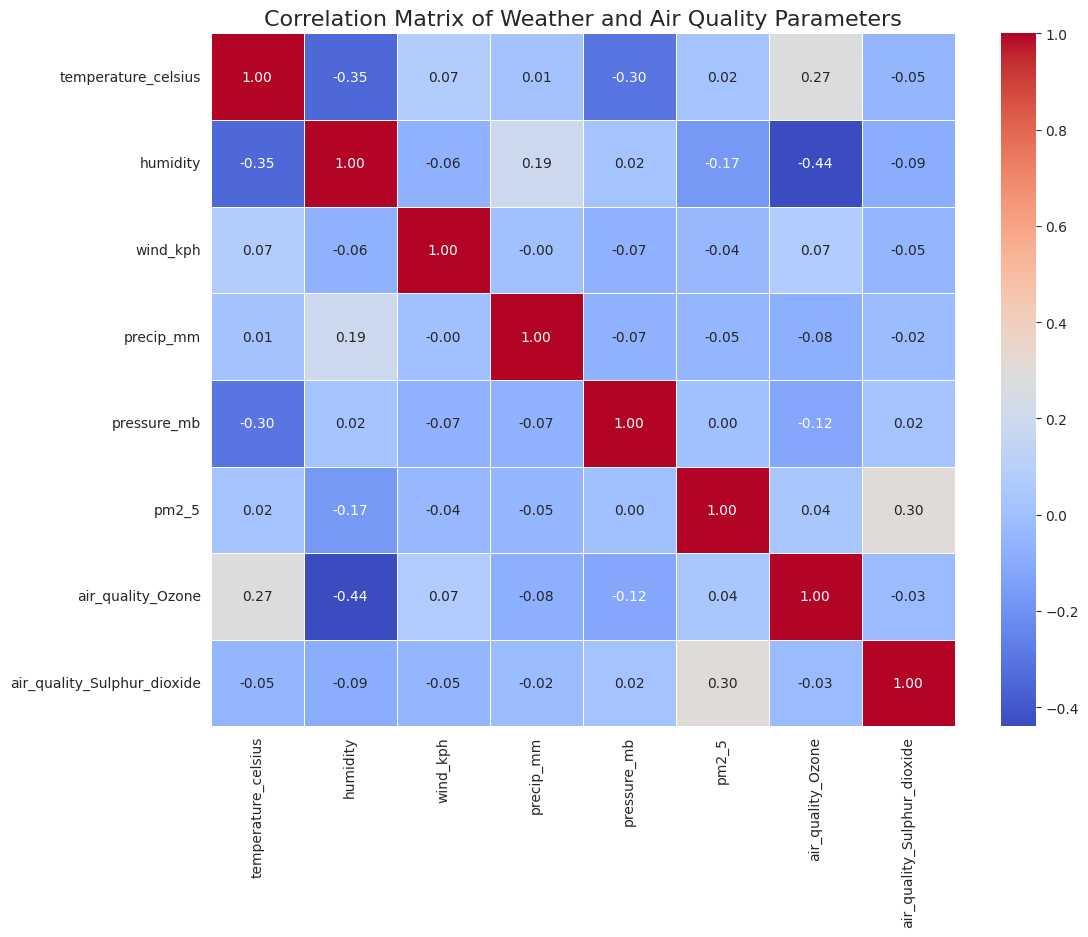

In [44]:
# --- Environmental Impact: Correlation Analysis ---
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of key features for a readable correlation matrix
correlation_features = [
    'temperature_celsius',
    'humidity',
    'wind_kph',
    'precip_mm',
    'pressure_mb',
    'pm2_5', # This is our key air quality metric
    'air_quality_Ozone',
    'air_quality_Sulphur_dioxide'
]

# Calculate the correlation matrix
corr_matrix = df[correlation_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Weather and Air Quality Parameters', fontsize=16)
plt.show()

# --- How to read this chart ---
# - Values close to +1.0 (dark red) mean a strong positive correlation (when one goes up, the other goes up).
# - Values close to -1.0 (dark blue) mean a strong negative correlation (when one goes up, the other goes down).
# - Values close to 0 (light colors) mean little to no correlation.

# dashboard

In [ ]:
# --- Step 1: Save the necessary assets for the dashboard ---
import pandas as pd
import joblib

# Let's assume 'merged_data' is your final GeoDataFrame with all stats
# and 'xgb_model' is your trained forecasting model.
# We also need the scaler.

# Save the processed data for the maps
merged_data.to_csv('dashboard_geodata.csv', index=False)

# Save the trained model and the scaler
joblib.dump(xgb_model, 'forecasting_model.pkl')
joblib.dump(scaler, 'scaler.pkl') # Assuming 'scaler' is your StandardScaler object

# We also need a sample of the city data for forecasting columns
city_df.to_csv('london_sample_data.csv', index=True)

print("✅ Assets for dashboard have been saved successfully.")

✅ Assets for dashboard have been saved successfully.
